# Unit02｜化工時間序列清理 SOP + 製程監控特徵

對應講義：`Part_1/Unit02_TimeSeries_Cleaning.md`


In [1]:
# ===== Shared environment (repo-root + outputs/) =====
import os, sys
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

def find_repo_root(start=None):
    start = Path(start or os.getcwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / 'Jupyter_Scripts').is_dir():
            return p
    if IN_COLAB:
        candidate = Path('/content/drive/MyDrive/ChemEng_AI_Course_Materials')
        if (candidate / 'Jupyter_Scripts').is_dir():
            return candidate
    return start

REPO_ROOT = find_repo_root()
# Part_1 課程結果儲存在 Part_1 資料夾內
PART1_DIR = REPO_ROOT / 'Part_1'
OUTPUT_DIR = PART1_DIR / 'Unit02_Results'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(PART1_DIR)
print('REPO_ROOT:', REPO_ROOT)
print('PART1_DIR:', PART1_DIR)
print('Working dir:', os.getcwd())
print('Results will be saved to:', OUTPUT_DIR)


REPO_ROOT: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials
PART1_DIR: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_1
Working dir: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_1
Results will be saved to: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_1\Unit02_Results


In [2]:
# 匯入必要的套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

def configure_warnings():
    # 僅忽略常見非關鍵警告，避免過度隱藏重要訊息
    warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')
    warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

configure_warnings()

# 建立結果儲存資料夾（已在上一個 cell 設定好路徑）
# os.makedirs('Unit02_Results', exist_ok=True)  # 不需要，已在上方創建

# 設定繪圖風格（支援中文顯示，方便標註物理量與單位）
sns.set(style='whitegrid')
#plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

print('套件載入完成！目前執行環境：Pandas', pd.__version__, 'NumPy', np.__version__)


套件載入完成！目前執行環境：Pandas 2.2.3 NumPy 1.26.4


## 🛡️ 化工時序數據健康檢查函數

在處理任何時序數據前，先定義健康檢查工具。這個函數將在後續章節中使用，特別是在**第3章「十大陷阱診斷」**中發揮作用。

> 💡 學習提示：先不用深究每個檢查項目的細節，隨著後續實作，你會逐漸理解每個檢查的意義。

In [3]:
def chemeng_data_health_check(df, time_col=None, value_cols=None):
    """
    化工時序數據健康檢查函數
    
    Parameters:
    -----------
    df : DataFrame
        時間序列數據（若 time_col=None 則假設 index 為 DatetimeIndex）
    time_col : str, optional
        時間欄位名稱
    value_cols : list, optional
        需檢查的數值欄位（若 None 則檢查所有數值欄）
    
    Returns:
    --------
    dict : 診斷報告
    """
    import numpy as np
    import pandas as pd
    
    report = {}
    
    # 1. 時間索引檢查
    if time_col:
        df = df.set_index(time_col)
    if not isinstance(df.index, pd.DatetimeIndex):
        report['時間索引'] = '❌ 非 DatetimeIndex'
        return report
    else:
        report['時間索引'] = '✅ 正確'
    
    # 2. 時區檢查
    if df.index.tz is None:
        report['時區'] = '⚠️ 無時區資訊（建議設定 UTC）'
    else:
        report['時區'] = f'✅ {df.index.tz}'
    
    # 3. 採樣間隔檢查
    time_diffs = df.index.to_series().diff().dropna()
    if time_diffs.nunique() > 1:
        report['採樣間隔'] = f'⚠️ 非等距（{time_diffs.nunique()} 種間隔）'
        report['採樣間隔分佈'] = time_diffs.value_counts().head(5).to_dict()
    else:
        report['採樣間隔'] = f'✅ 等距（{time_diffs.iloc[0]}）'
    
    # 4. 缺失值檢查
    if value_cols is None:
        value_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    missing_report = {}
    for col in value_cols:
        missing_pct = df[col].isna().mean() * 100
        max_gap = df[col].isna().astype(int).groupby(df[col].notna().cumsum()).sum().max()
        missing_report[col] = {
            '缺失比例': f'{missing_pct:.1f}%',
            '最長連續缺失': f'{max_gap} 點'
        }
    report['缺失值'] = missing_report
    
    # 5. 物理極限檢查（示例：可根據實際設備調整）
    limit_violations = {}
    for col in value_cols:
        if 'temp' in col.lower() or 't_' in col.lower():
            violations = ((df[col] < -50) | (df[col] > 400)).sum()
            if violations > 0:
                limit_violations[col] = f'❌ {violations} 筆超出 [-50, 400]'
        elif 'press' in col.lower() or 'p_' in col.lower():
            violations = ((df[col] < 0) | (df[col] > 50)).sum()
            if violations > 0:
                limit_violations[col] = f'❌ {violations} 筆超出 [0, 50]'
        elif 'flow' in col.lower() or 'f_' in col.lower():
            violations = (df[col] < 0).sum()
            if violations > 0:
                limit_violations[col] = f'❌ {violations} 筆為負值'
    
    if limit_violations:
        report['物理極限'] = limit_violations
    else:
        report['物理極限'] = '✅ 無明顯違反'
    
    # 6. 數值分佈檢查（多峰性 → 可能單位不一致）
    distribution_check = {}
    for col in value_cols:
        if df[col].notna().sum() > 100:  # 至少 100 筆有效值
            # 簡易多峰檢測：標準化後計算峰度
            standardized = (df[col] - df[col].mean()) / df[col].std()
            kurtosis = standardized.kurtosis()
            if abs(kurtosis) > 5:  # 高峰度可能代表多峰
                distribution_check[col] = f'⚠️ 峰度 {kurtosis:.2f}（可能多峰/單位不一致）'
    
    if distribution_check:
        report['數值分佈'] = distribution_check
    else:
        report['數值分佈'] = '✅ 無異常'
    
    # 7. 停機段檢測（假設：多個關鍵變數同時接近零）
    if len(value_cols) >= 3:
        near_zero = (df[value_cols].abs() < 1e-3).all(axis=1).sum()
        shutdown_pct = near_zero / len(df) * 100
        if shutdown_pct > 5:
            report['停機段'] = f'⚠️ {shutdown_pct:.1f}% 時間疑似停機（多變數接近零）'
        else:
            report['停機段'] = '✅ 無明顯停機段'
    
    return report

# 使用範例（將在後續 cell 中測試）
print("✅ 健康檢查函數已載入")

✅ 健康檢查函數已載入


---
## 1. 化工時間序列處理 (Time Series Handling)

化工製程數據（溫度、壓力、流量）通常帶有時間戳記。
這裡我們模擬一個反應器的溫度數據，練習如何處理缺失值與重採樣。

> 在實務中，以下情況非常常見：
> - 不同感測器的採樣頻率不同（1s、10s、1min），需要對齊時間軸。
> - 感測器偶爾斷訊，造成資料中有 NaN，需要用合理方式補值。
> - 原始數據太密太吵，做模型前想先「壓平」成較低頻的趨勢資料。

### 1.1 時間物件轉換與索引
目標：將多來源、不一致的時間字串轉為統一的 DatetimeIndex。

**常見原始格式與對應 format**
- 2023/01/01 08:00:00  -> '%Y/%m/%d %H:%M:%S'
- 01-02-2023 14:30     -> '%d-%m-%Y %H:%M' (或月日年，需 dayfirst)
- 2023-03-05T09:15:30Z -> ISO 8601，自動偵測，可用 utc=True
- 20230106 101500      -> '%Y%m%d %H%M%S'
- 07/01/2023 23:45     -> 易混淆（日/月），用 dayfirst 控制

**pd.to_datetime 重要參數**
- format: 指定解析模板（最快，避免推斷錯誤）
- infer_datetime_format=True: 讓 pandas 推斷（多格式但較慢）
- errors='coerce': 無法解析→NaT，方便後續補值或過濾
- dayfirst=True: 解析歐洲格式日/月/年
- utc=True: 直接產生 UTC（跨平台同步）

**時區 (timezone)**
本地時間先 tz_localize('Asia/Taipei') 再 tz_convert('UTC') 標準化。

**拆分日期與時間欄**
df['Date'] + ' ' + df['Time'] → pd.to_datetime(...)；避免逐列 apply。

**效能建議**
大資料 (>10^6 rows) 指定 format；混合格式先分組 parse；保留 NaT 比例供品質檢查。

**練習：下方程式展示多格式解析、錯誤處理與時區轉換。

In [4]:
# 2.1 多格式解析練習
import pandas as pd

raw_samples = [
    '2023/01/01 08:00:00',   # slash
    '01-02-2023 14:30',      # day-month-year
    '2023-03-05T09:15:30Z',  # ISO UTC
    '20230106 101500',       # compact
    '07/01/2023 23:45',      # ambiguous
    'BAD_STRING',            # invalid
]
df_fmt = pd.DataFrame({'raw_ts': raw_samples})

# 1. 直接自動解析 (含 UTC ISO)：
df_fmt['dt_auto'] = pd.to_datetime(df_fmt['raw_ts'], errors='coerce', utc=True)

# 2. 指定 format 解析第一種（其他會 NaT）：
df_fmt['dt_slash'] = pd.to_datetime(df_fmt['raw_ts'], format='%Y/%m/%d %H:%M:%S', errors='coerce')

# 3. 解析 day-first 潛在格式：
df_fmt['dt_dayfirst'] = pd.to_datetime(df_fmt['raw_ts'], dayfirst=True, errors='coerce')

# 4. 解析壓縮格式：
df_fmt['dt_compact'] = pd.to_datetime(df_fmt['raw_ts'], format='%Y%m%d %H%M%S', errors='coerce')

print('[多格式解析結果]')
display(df_fmt)

# 統計解析失敗比例：
fail_rate = df_fmt['dt_auto'].isna().mean()
print('自動解析失敗比例:', f'{fail_rate:.2%}')

[多格式解析結果]


,raw_ts,dt_auto,dt_slash,dt_dayfirst,dt_compact
0,2023/01/01 08:00:00,2023-01-01 08:00:00+00:00,2023-01-01 08:00:00,2023-01-01 08:00:00,NaT
1,01-02-2023 14:30,NaT,NaT,NaT,NaT
2,2023-03-05T09:15:30Z,NaT,NaT,NaT,NaT
3,20230106 101500,NaT,NaT,NaT,2023-01-06 10:15:00
4,07/01/2023 23:45,NaT,NaT,NaT,NaT
5,BAD_STRING,NaT,NaT,NaT,NaT


自動解析失敗比例: 83.33%


In [5]:
# 2.1 拆分欄位與時區練習 (修正：逐列時區本地化)
import pandas as pd, pytz

df_sep = pd.DataFrame({
    'Date': ['2023-01-08', '2023-01-08'],
    'Time': ['08:30:00', '08:30:00'],
    'TZ': ['Asia/Taipei', 'America/New_York']
})
print('[原始資料]')
display(df_sep)

# 建立 naive datetime（尚未附時區）
dt_series = pd.to_datetime(df_sep['Date'] + ' ' + df_sep['Time'], errors='coerce')

# 逐列附加各自時區（無法用 .dt.tz_localize 傳入 Series）
localized = [dt.tz_localize(tz) for dt, tz in zip(dt_series, df_sep['TZ'])]
df_sep['Timestamp_local'] = localized

# 統一轉換為 UTC
df_sep['Timestamp_UTC'] = [ts.astimezone(pytz.UTC) for ts in df_sep['Timestamp_local']]

print('[本地與 UTC 範例]')
display(df_sep)

# 設 UTC 為索引
df_sep = df_sep.set_index('Timestamp_UTC')
print('[設定 UTC 為索引]')
display(df_sep[['Date','Time','TZ','Timestamp_local']])

[原始資料]


,Date,Time,TZ
0,2023-01-08,08:30:00,Asia/Taipei
1,2023-01-08,08:30:00,America/New_York


[本地與 UTC 範例]


,Date,Time,TZ,Timestamp_local,Timestamp_UTC
0,2023-01-08,08:30:00,Asia/Taipei,2023-01-08 08:30:00+08:00,2023-01-08 00:30:00+00:00
1,2023-01-08,08:30:00,America/New_York,2023-01-08 08:30:00-05:00,2023-01-08 13:30:00+00:00


[設定 UTC 為索引]


,Date,Time,TZ,Timestamp_local
Timestamp_UTC,,,,
2023-01-08 00:30:00+00:00,2023-01-08,08:30:00,Asia/Taipei,2023-01-08 08:30:00+08:00
2023-01-08 13:30:00+00:00,2023-01-08,08:30:00,America/New_York,2023-01-08 08:30:00-05:00


In [6]:
# 1. 產生模擬數據
# 建立時間範圍：從 08:00 到 08:10，每 10 秒一筆
dates = pd.date_range(start="2023-01-01 08:00:00", periods=61, freq="10s")

# 模擬溫度數據 (正弦波 + 雜訊)
temps = 100 + 10 * np.sin(np.linspace(0, 3.14, 61)) + np.random.normal(0, 0.5, 61)

df_ts = pd.DataFrame({"Timestamp": dates, "Temperature": temps})

# 人為製造缺失值 (模擬感測器斷訊)
df_ts.loc[10:15, "Temperature"] = np.nan

print("[原始數據前 5 筆]")
display(df_ts.head())
print("Timestamp 型別:", df_ts['Timestamp'].dtype)

[原始數據前 5 筆]


,Timestamp,Temperature
0,2023-01-01 08:00:00,100.245146
1,2023-01-01 08:00:10,100.423855
2,2023-01-01 08:00:20,100.338436
3,2023-01-01 08:00:30,101.794906
4,2023-01-01 08:00:40,102.297198


Timestamp 型別: datetime64[ns]


In [7]:
# 2. 轉換為 Datetime 物件並設為索引
# 雖然 pd.date_range 產生的是 datetime，但讀 CSV 時通常是 object (str)，這裡示範標準 SOP
df_ts["Timestamp"] = pd.to_datetime(df_ts["Timestamp"])
df_ts.set_index("Timestamp", inplace=True)
print("[設定索引後]")
display(df_ts.head(3))
# 小練習：請嘗試取出 2023-01-01 08:02:00 到 08:05:00 之間的資料（使用時間切片語法）。

[設定索引後]


,Temperature
Timestamp,
2023-01-01 08:00:00,100.245146
2023-01-01 08:00:10,100.423855
2023-01-01 08:00:20,100.338436


In [8]:
# 練習解答示範：時間切片 (可自行刪除或保留)
slice_df = df_ts.loc["2023-01-01 08:02:00":"2023-01-01 08:05:00"]
display(slice_df)

,Temperature
Timestamp,
2023-01-01 08:02:00,NaN
2023-01-01 08:02:10,NaN
2023-01-01 08:02:20,NaN
2023-01-01 08:02:30,NaN
2023-01-01 08:02:40,108.118419
2023-01-01 08:02:50,107.876420
2023-01-01 08:03:00,107.958869
2023-01-01 08:03:10,108.392614
2023-01-01 08:03:20,109.136747


### 1.2 缺失值處理：插值法 (Interpolate)


--- 補值前 (Index 10-15 是 NaN) ---


,Temperature
Timestamp,
2023-01-01 08:01:30,104.555881
2023-01-01 08:01:40,NaN
2023-01-01 08:01:50,NaN
2023-01-01 08:02:00,NaN
2023-01-01 08:02:10,NaN
2023-01-01 08:02:20,NaN
2023-01-01 08:02:30,NaN
2023-01-01 08:02:40,108.118419



--- 補值後 ---


,Temperature,Temp_Filled
Timestamp,,
2023-01-01 08:01:30,104.555881,104.555881
2023-01-01 08:01:40,NaN,105.064815
2023-01-01 08:01:50,NaN,105.573749
2023-01-01 08:02:00,NaN,106.082683
2023-01-01 08:02:10,NaN,106.591617
2023-01-01 08:02:20,NaN,107.100551
2023-01-01 08:02:30,NaN,107.609485
2023-01-01 08:02:40,108.118419,108.118419


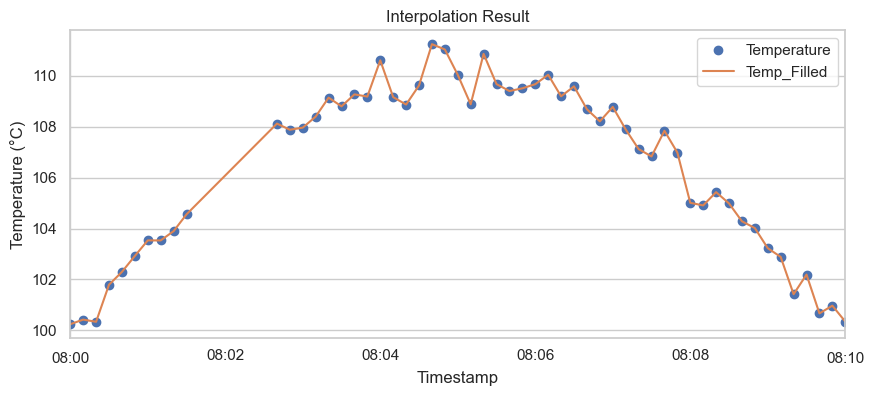

In [9]:
# 對於連續變化的物理量（如溫度），用「時間插值」比填補平均值更合理

print("--- 補值前 (Index 10-15 是 NaN) ---")
display(df_ts.iloc[9:17])

# 使用時間加權插值
df_ts["Temp_Filled"] = df_ts["Temperature"].interpolate(method="time")

print("\n--- 補值後 ---")
display(df_ts.iloc[9:17][["Temperature", "Temp_Filled"]])

# 繪圖比較
df_ts[["Temperature", "Temp_Filled"]].plot(style=['o', '-'], figsize=(10, 4), title="Interpolation Result")
plt.ylabel("Temperature (°C)")
plt.savefig('./Unit02_Results/01_interpolation.png')
plt.show()

### 1.3 重採樣 (Resampling)


In [10]:

# 將 10 秒級數據降採樣為 1 分鐘級數據 (取平均)
# 這在處理高頻數據以減少資料量時非常有用

# 註：在部分 pandas 版本中，resample().mean(numeric_only=True) 會觸發
# UnsupportedFunctionCall，建議直接使用 mean() 或先選 numeric 欄位。
df_1min = df_ts.resample("1min").mean()

print("[重採樣：10s -> 1min 平均值]")
display(df_1min[["Temp_Filled"]])

# 想一想：如果是安全相關變數（如壓力超壓），你會用 mean 還是 max 來聚合？

[重採樣：10s -> 1min 平均值]


,Temp_Filled
Timestamp,
2023-01-01 08:00:00,101.337111
2023-01-01 08:01:00,104.359274
2023-01-01 08:02:00,107.229862
2023-01-01 08:03:00,108.787836
2023-01-01 08:04:00,110.083355
2023-01-01 08:05:00,109.721218
2023-01-01 08:06:00,109.225632
2023-01-01 08:07:00,107.571335
2023-01-01 08:08:00,104.771296


### 1.4 前後填充 (Forward/Backward Fill)


In [11]:

# 適用於狀態數據（例如：閥門開度、設定值 SP），在下一次改變前應維持原值
# 模擬一個閥門開度數據，中間有缺失
df_valve = pd.DataFrame({
    'Time': pd.date_range(start="2023-01-01 08:00:00", periods=6, freq="1min"),
    'Valve_Pos': [50, np.nan, np.nan, 80, np.nan, 80]
}).set_index('Time')

print("--- 原始閥門數據 (含缺失) ---")
display(df_valve)

# ffill: 用前一筆有效值填補 (狀態維持)
df_valve['FFill'] = df_valve['Valve_Pos'].ffill()
# bfill: 用後一筆有效值填補
df_valve['BFill'] = df_valve['Valve_Pos'].bfill()

print("--- 填補後比較 ---")
display(df_valve)

# 思考：對於「批次結束時間」這種事件，你會用哪一種填補方式？或者乾脆不補？

--- 原始閥門數據 (含缺失) ---


,Valve_Pos
Time,
2023-01-01 08:00:00,50.0
2023-01-01 08:01:00,NaN
2023-01-01 08:02:00,NaN
2023-01-01 08:03:00,80.0
2023-01-01 08:04:00,NaN
2023-01-01 08:05:00,80.0


--- 填補後比較 ---


,Valve_Pos,FFill,BFill
Time,,,
2023-01-01 08:00:00,50.0,50.0,50.0
2023-01-01 08:01:00,NaN,50.0,80.0
2023-01-01 08:02:00,NaN,50.0,80.0
2023-01-01 08:03:00,80.0,80.0,80.0
2023-01-01 08:04:00,NaN,80.0,80.0
2023-01-01 08:05:00,80.0,80.0,80.0


### 1.5 化工實務中常見的時間序列清理流程
串接：欄位過濾 → 對齊 → 缺失處理 → 異常標記 → 標準化。

#### 1.5.1 欄位過濾

In [12]:
# Step 0：合成一個「看起來像 DCS 匯出」的小型資料集
np.random.seed(1)

# 三個不同頻率的時間索引
idx_T = pd.date_range("2023-01-01 00:00", periods=121, freq="1min")   # 每分鐘
idx_F = pd.date_range("2023-01-01 00:00", periods=31, freq="5min")    # 每 5 分鐘
idx_P = pd.date_range("2023-01-01 00:00", periods=13, freq="10min")   # 每 10 分鐘

# 溫度：目標 80℃，含隨機波動
T_reactor = pd.Series(80 + np.random.normal(0, 1, len(idx_T)), index=idx_T, name="T_reactor")

# 流量：目標 1000 kg/h，含慢變趨勢
F_feed = pd.Series(
    1000 + np.linspace(-50, 50, len(idx_F)) + np.random.normal(0, 5, len(idx_F)),
    index=idx_F,
    name="F_feed",
)

# 壓力：目標 10 bar，含噪音 + 一段異常飆高
P_reactor = pd.Series(10 + np.random.normal(0, 0.3, len(idx_P)), index=idx_P, name="P_reactor")
P_reactor.iloc[5:8] += 3  # 模擬一段異常高壓

# 故意插入部分缺失值
T_reactor.iloc[20:30] = np.nan        # 長時間斷訊
F_feed.iloc[[3, 10, 20]] = np.nan     # 零星缺失

print("=== 原始三個感測器的範例 ===")
display(T_reactor.head())
display(F_feed.head())
display(P_reactor.head())

=== 原始三個感測器的範例 ===


2023-01-01 00:00:00    81.624345
2023-01-01 00:01:00    79.388244
2023-01-01 00:02:00    79.471828
2023-01-01 00:03:00    78.927031
2023-01-01 00:04:00    80.865408
Freq: min, Name: T_reactor, dtype: float64

2023-01-01 00:00:00    946.124192
2023-01-01 00:05:00    959.702113
2023-01-01 00:10:00    966.502175
2023-01-01 00:15:00           NaN
2023-01-01 00:20:00    969.514153
Freq: 5min, Name: F_feed, dtype: float64

2023-01-01 00:00:00    10.311647
2023-01-01 00:10:00    10.656094
2023-01-01 00:20:00    10.132409
2023-01-01 00:30:00     9.969953
2023-01-01 00:40:00     9.959067
Freq: 10min, Name: P_reactor, dtype: float64

#### 1.5.2 時間對齊 (Alignment)

In [13]:
# Step 1/2：欄位過濾 + 時間對齊 (正確的上/降頻處理)
common_idx = idx_T  # 1min 標準格點
df_pipe = pd.DataFrame(index=common_idx)

# 溫度已是 1min
df_pipe["T_reactor"] = T_reactor

# 流量 5min -> 1min：使用 reindex (增加格點) 後時間插值
df_pipe["F_feed"] = F_feed.reindex(common_idx).interpolate(method="time")

# 壓力 10min -> 1min：同樣方式
df_pipe["P_reactor"] = P_reactor.reindex(common_idx).interpolate(method="time")

print("=== 對齊與插值後前 10 筆 ===")
display(df_pipe.head(10))

=== 對齊與插值後前 10 筆 ===


,T_reactor,F_feed,P_reactor
2023-01-01 00:00:00,81.624345,946.124192,10.311647
2023-01-01 00:01:00,79.388244,948.839776,10.346092
2023-01-01 00:02:00,79.471828,951.555360,10.380537
2023-01-01 00:03:00,78.927031,954.270945,10.414981
2023-01-01 00:04:00,80.865408,956.986529,10.449426
2023-01-01 00:05:00,77.698461,959.702113,10.483871
2023-01-01 00:06:00,81.744812,961.062125,10.518315
2023-01-01 00:07:00,79.238793,962.422138,10.552760
2023-01-01 00:08:00,80.319039,963.782150,10.587205
2023-01-01 00:09:00,79.750630,965.142163,10.621649


#### 1.5.3 缺失值處理

In [14]:
# Step 3：缺失值處理 + 生產有效標記
df_pipe["is_T_missing"] = df_pipe["T_reactor"].isna()

# 生產有效旗標：長時間溫度缺失視為非生產/停機
df_pipe["is_valid"] = ~df_pipe["is_T_missing"]

print("T_reactor 缺失區段 (前幾筆)：")
display(df_pipe[df_pipe["is_T_missing"]].head())

# 線性時間插值填補（若後續需要完整矩陣，可用；建模時亦可只用 is_valid==True）
df_pipe["T_reactor_filled"] = df_pipe["T_reactor"].interpolate("time")

print("=== 填補前後比較 (T_reactor) ===")
display(df_pipe.loc["2023-01-01 00:15":"2023-01-01 00:40", ["T_reactor", "T_reactor_filled", "is_valid"]])

T_reactor 缺失區段 (前幾筆)：


,T_reactor,F_feed,P_reactor,is_T_missing,is_valid
2023-01-01 00:20:00,NaN,969.514153,10.132409,True,False
2023-01-01 00:21:00,NaN,970.572307,10.116164,True,False
2023-01-01 00:22:00,NaN,971.630460,10.099918,True,False
2023-01-01 00:23:00,NaN,972.688614,10.083673,True,False
2023-01-01 00:24:00,NaN,973.746767,10.067427,True,False


=== 填補前後比較 (T_reactor) ===


,T_reactor,T_reactor_filled,is_valid
2023-01-01 00:15:00,78.900109,78.900109,True
2023-01-01 00:16:00,79.827572,79.827572,True
2023-01-01 00:17:00,79.122142,79.122142,True
2023-01-01 00:18:00,80.042214,80.042214,True
2023-01-01 00:19:00,80.582815,80.582815,True
2023-01-01 00:20:00,NaN,80.466954,False
2023-01-01 00:21:00,NaN,80.351092,False
2023-01-01 00:22:00,NaN,80.235231,False
2023-01-01 00:23:00,NaN,80.119369,False
2023-01-01 00:24:00,NaN,80.003508,False


#### 1.5.4 異常值偵測：物理界線 + 統計方法
建議：先用工程極限剔除不可能值，再用移動均值±kσ標記統計異常。

In [15]:
# 2.5.4 異常值偵測範例 (工程極限 + 統計)
# 依前步驟 df_pipe 已包含 T_reactor / P_reactor (1min 對齊後)
eng_limits = {"T_reactor": (70, 90), "P_reactor": (8, 15)}
low_T, high_T = eng_limits["T_reactor"]
low_P, high_P = eng_limits["P_reactor"]

# 工程極限過濾，建立 *_clean 欄位
df_pipe["T_reactor_clean"] = df_pipe["T_reactor"].where(
    (df_pipe["T_reactor"] >= low_T) & (df_pipe["T_reactor"] <= high_T)
)
df_pipe["P_reactor_clean"] = df_pipe["P_reactor"].where(
    (df_pipe["P_reactor"] >= low_P) & (df_pipe["P_reactor"] <= high_P)
)

# 工程極限異常標記
df_pipe["T_outlier_eng"] = df_pipe["T_reactor_clean"].isna()
df_pipe["P_outlier_eng"] = df_pipe["P_reactor_clean"].isna()

# 統計異常：滾動視窗 (15 分鐘)
win = 15
roll_mean = df_pipe["P_reactor_clean"].rolling(win, min_periods=5).mean()
roll_std = df_pipe["P_reactor_clean"].rolling(win, min_periods=5).std()
df_pipe["P_outlier_stat"] = (
    (df_pipe["P_reactor_clean"] > roll_mean + 3 * roll_std) |
    (df_pipe["P_reactor_clean"] < roll_mean - 3 * roll_std)
)

print("工程極限異常 T, P:", df_pipe["T_outlier_eng"].sum(), df_pipe["P_outlier_eng"].sum())
print("統計異常 P:", df_pipe["P_outlier_stat"].sum())

# 顯示部分異常列
display(df_pipe.loc[df_pipe["P_outlier_stat"], ["P_reactor", "P_reactor_clean", "P_outlier_stat"]].head())

工程極限異常 T, P: 10 0
統計異常 P: 2


,P_reactor,P_reactor_clean,P_outlier_stat
2023-01-01 00:41:00,10.259588,10.259588,True
2023-01-01 00:42:00,10.560110,10.560110,True


#### 1.5.5 標準化 / 正規化：z-score 距離比較小實驗
示範不同尺度變數經 z-score 後距離貢獻均衡。

In [16]:
# z-score 距離比較實驗
np.random.seed(42)
n_normal = 200
T_normal = np.random.normal(loc=80, scale=1, size=n_normal)
P_normal = np.random.normal(loc=10, scale=0.3, size=n_normal)
F_normal = np.random.normal(loc=1000, scale=100, size=n_normal)
df_normal = pd.DataFrame({'T': T_normal, 'P': P_normal, 'F': F_normal})
anomaly = pd.DataFrame({'T': [85], 'P': [12], 'F': [1300]})
print("[正常操作點統計]")
display(df_normal.describe())
print("[異常點]")
display(anomaly)
center_raw = df_normal.mean()
diff_raw = anomaly.iloc[0] - center_raw
d_raw = np.sqrt((diff_raw ** 2).sum())
print(f"原始空間距離: {d_raw:.2f}")
print("原始差值:")
print(diff_raw)
from sklearn.preprocessing import StandardScaler
scaler_demo = StandardScaler()
df_all = pd.concat([df_normal, anomaly], ignore_index=True)
df_all_z = pd.DataFrame(scaler_demo.fit_transform(df_all), columns=['T_z', 'P_z', 'F_z'])
df_normal_z = df_all_z.iloc[:n_normal]
anomaly_z = df_all_z.iloc[n_normal]
center_z = df_normal_z.mean()
diff_z = anomaly_z - center_z
d_z = np.sqrt((diff_z ** 2).sum())
print(f"z-score 空間距離: {d_z:.2f}")
print("z-score 差值 (各維度標準差尺度):")
print(diff_z)

[正常操作點統計]


,T,P,F
count,200.000000,200.000000,200.000000
mean,79.959229,10.025760,991.434497
std,0.931004,0.296101,99.404197
min,77.380255,9.027620,752.835550
25%,79.294872,9.818249,920.612156
50%,79.995808,10.023652,992.240008
75%,80.500852,10.206169,1057.208824
max,82.720169,11.155819,1307.888081


[異常點]


,T,P,F
0,85,12,1300


原始空間距離: 308.61
原始差值:
T      5.040771
P      1.974240
F    308.565503
dtype: float64
z-score 空間距離: 8.48
z-score 差值 (各維度標準差尺度):
T_z    5.081769
P_z    6.061023
F_z    3.047167
dtype: float64


## 2. 化工數據實戰：反應器製程監控 (Process Monitoring)

在化工廠中，我們常需要對感測器數據進行「平滑化」以去除雜訊，或計算「變化率」來偵測異常波動。
本案例模擬一個反應器的壓力數據，練習以下 Pandas 高階技巧：
1.  **Rolling Window (滑動視窗)**：計算移動平均 (Moving Average)，用於降噪。
2.  **Diff (差分)**：計算當前時刻與上一時刻的差值，用於偵測劇烈變化。

> 實務應用例子：
> - 當壓力變化率過大時啟動安全聯鎖（Safety Interlock），防止爆炸或洩壓閥過度動作。
> - 用滑動平均平滑後的信號作為後端軟感測器 (Soft Sensor) 模型的輸入，提升預測穩定度。

### 2.1 滑動視窗 (Rolling Window) - 降噪
目的：以移動平均平滑高頻雜訊並保留趨勢。

[3.1 原始 vs 移動平均 前 8 筆]


,Pressure,MA_5
2023-01-01 09:00:00,10.248357,10.248357
2023-01-01 09:01:00,9.930868,10.089612
2023-01-01 09:02:00,10.323844,10.167690
2023-01-01 09:03:00,10.761515,10.316146
2023-01-01 09:04:00,9.882923,10.229501
2023-01-01 09:05:00,9.882932,10.156416
2023-01-01 09:06:00,10.789606,10.328164
2023-01-01 09:07:00,10.383717,10.340139


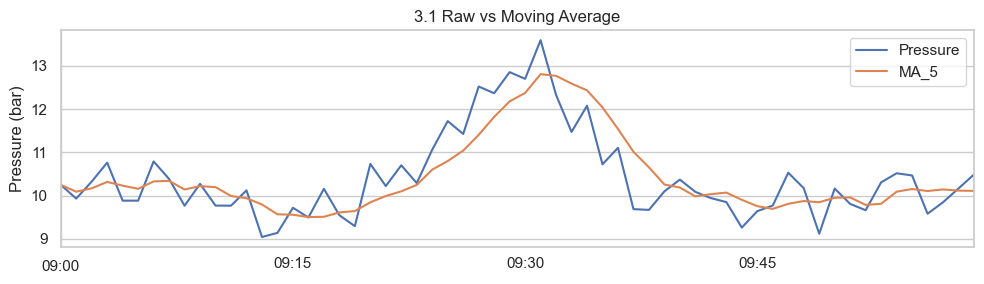

In [17]:
# 1. 模擬反應器壓力數據 (含雜訊與異常)
# 設定時間索引：1小時數據，每分鐘一筆
rng = pd.date_range('2023-01-01 09:00', periods=60, freq='1min')
df_reactor = pd.DataFrame(index=rng)

# 模擬正常壓力 (基線 10 bar + 高斯雜訊)
np.random.seed(42)
df_reactor['Pressure'] = 10 + np.random.normal(0, 0.5, 60)

# 模擬異常：第 20-30 分鐘壓力逐漸升高 (偏移)
df_reactor.iloc[20:30, 0] += np.linspace(0, 3, 10)
# 模擬異常：第 30-40 分鐘壓力恢復
df_reactor.iloc[30:40, 0] += np.linspace(3, 0, 10)

# 移動平均 (5 分鐘視窗)
df_reactor['MA_5'] = df_reactor['Pressure'].rolling(window=5, min_periods=1).mean()

print('[3.1 原始 vs 移動平均 前 8 筆]')
display(df_reactor.head(8))

ax = df_reactor[['Pressure','MA_5']].plot(figsize=(10,3), title='3.1 Raw vs Moving Average')
ax.set_ylabel('Pressure (bar)')
plt.tight_layout()
plt.savefig('./Unit02_Results/03_rolling_mean.png')
plt.show()

### 2.2 差分 (Diff) - 變化率偵測
目的：找出快速變化區段 (階躍 / 突波)。

[3.2 壓力變化率 範例列 19~26]


,Pressure,Delta_P
2023-01-01 09:19:00,9.293848,-0.252140
2023-01-01 09:20:00,10.732824,1.438976
2023-01-01 09:21:00,10.220445,-0.512379
2023-01-01 09:22:00,10.700431,0.479986
2023-01-01 09:23:00,10.287626,-0.412805
2023-01-01 09:24:00,11.061142,0.773516
2023-01-01 09:25:00,11.722128,0.660986


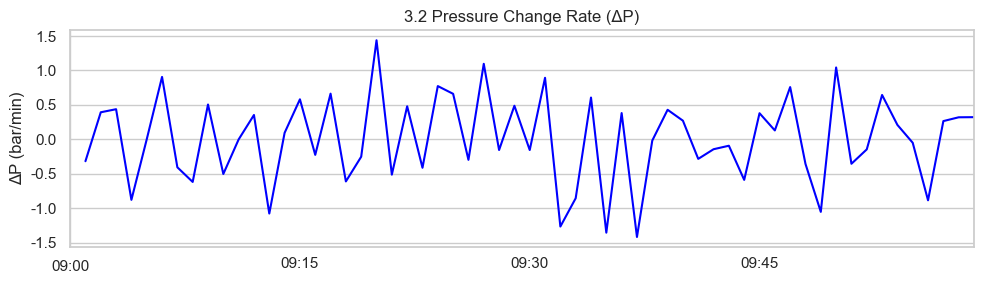

In [18]:
# 3.2 壓力變化率 (差分)
df_reactor['Delta_P'] = df_reactor['Pressure'].diff()
print('[3.2 壓力變化率 範例列 19~26]')
display(df_reactor.iloc[19:26][['Pressure','Delta_P']])

ax = df_reactor['Delta_P'].plot(figsize=(10,3), color='blue', title='3.2 Pressure Change Rate (ΔP)')
ax.set_ylabel('ΔP (bar/min)')
plt.tight_layout()
plt.savefig('./Unit02_Results/03_diff.png')
plt.show()

### 2.3 移動標準差 (Rolling Std) 與波動異常
目的：辨識壓力是否進入高波動不穩定區段。

[3.3 移動標準差與波動旗標 前 15 筆]


,Pressure,STD_5,HighVolFlag
2023-01-01 09:00:00,10.248357,NaN,False
2023-01-01 09:01:00,9.930868,NaN,False
2023-01-01 09:02:00,10.323844,0.208538,False
2023-01-01 09:03:00,10.761515,0.342271,False
2023-01-01 09:04:00,9.882923,0.354116,False
2023-01-01 09:05:00,9.882932,0.385565,False
2023-01-01 09:06:00,10.789606,0.446434,False
2023-01-01 09:07:00,10.383717,0.447091,False
2023-01-01 09:08:00,9.765263,0.434161,False
2023-01-01 09:09:00,10.271280,0.410571,False


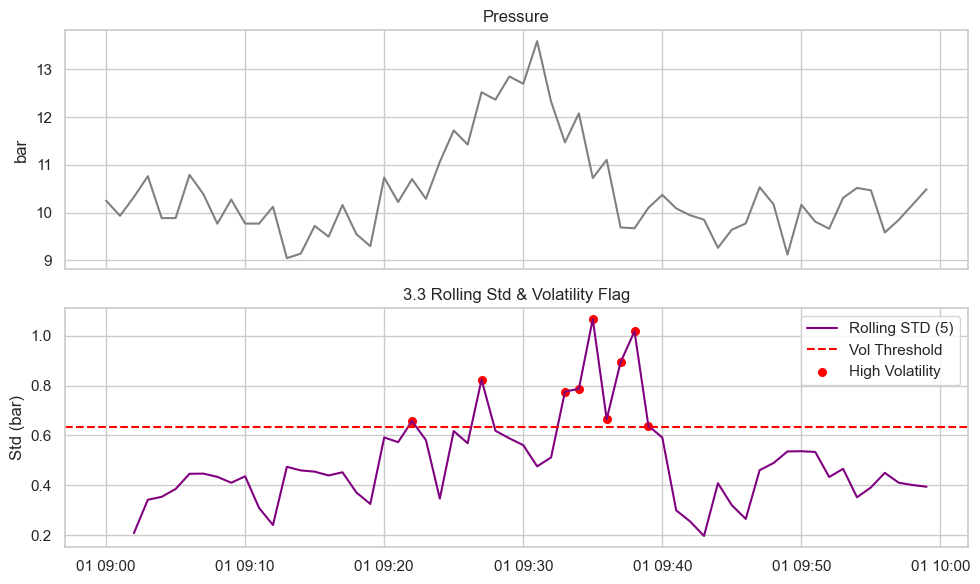

In [19]:
# 3.3 移動標準差 + 簡易波動異常旗標
df_reactor['STD_5'] = df_reactor['Pressure'].rolling(window=5, min_periods=3).std()
vol_threshold = df_reactor['STD_5'].median() + df_reactor['STD_5'].std()
df_reactor['HighVolFlag'] = df_reactor['STD_5'] > vol_threshold

print('[3.3 移動標準差與波動旗標 前 15 筆]')
display(df_reactor.head(15)[['Pressure','STD_5','HighVolFlag']])

fig, ax = plt.subplots(2,1,figsize=(10,6), sharex=True)
ax[0].plot(df_reactor.index, df_reactor['Pressure'], label='Pressure', color='gray')
ax[0].set_title('Pressure')
ax[0].set_ylabel('bar')
ax[1].plot(df_reactor.index, df_reactor['STD_5'], label='Rolling STD (5)', color='purple')
ax[1].axhline(vol_threshold, color='red', linestyle='--', label='Vol Threshold')
ax[1].scatter(df_reactor.index[df_reactor['HighVolFlag']],
              df_reactor['STD_5'][df_reactor['HighVolFlag']],
              color='red', s=30, label='High Volatility')
ax[1].set_title('3.3 Rolling Std & Volatility Flag')
ax[1].set_ylabel('Std (bar)')
ax[1].legend()
plt.tight_layout()
plt.savefig('./Unit02_Results/03_rolling_std.png')
plt.show()

### 2.4 綜合視覺化 (選擇性)
將降噪、變化率與波動指標整合於同一檢視。

### 2.5 測試健康檢查函數：使用製程監控數據

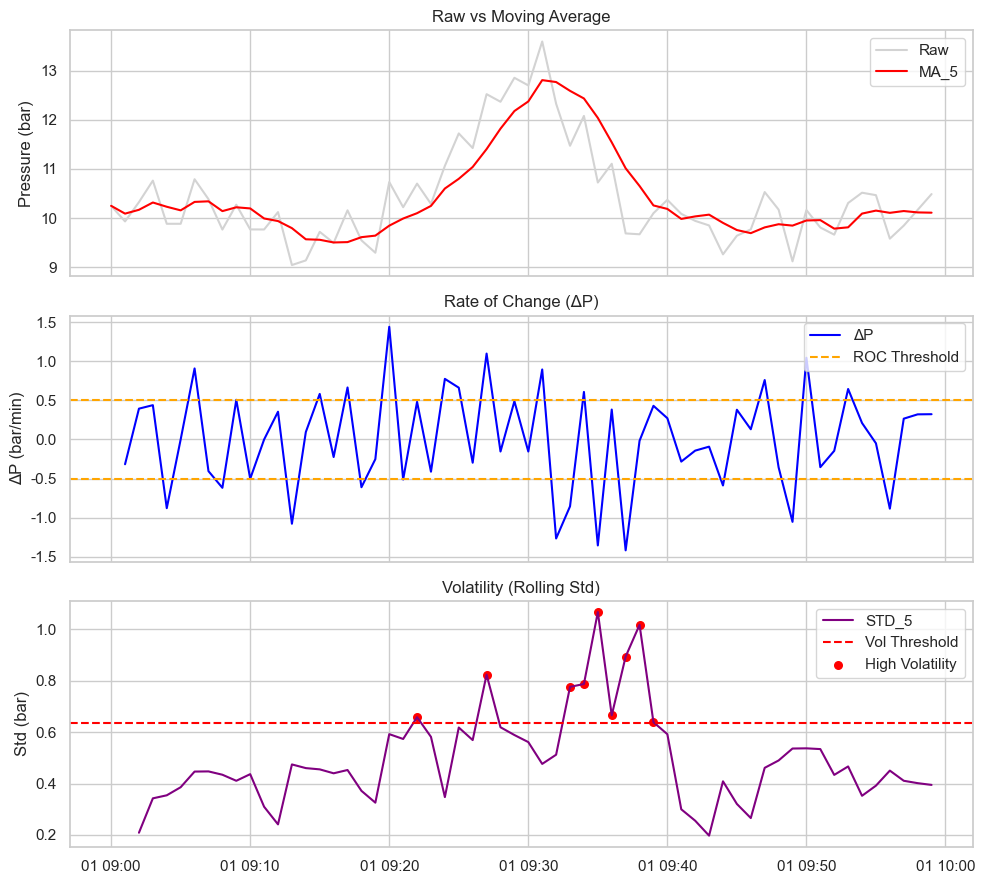

In [20]:
# 3.4 綜合視覺化：原始壓力 / MA / ΔP / 高波動標記
fig, ax = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

ax[0].plot(df_reactor.index, df_reactor['Pressure'], label='Raw', color='lightgray')
ax[0].plot(df_reactor.index, df_reactor['MA_5'], label='MA_5', color='red')
ax[0].set_title('Raw vs Moving Average')
ax[0].set_ylabel('Pressure (bar)')
ax[0].legend()

ax[1].plot(df_reactor.index, df_reactor['Delta_P'], label='ΔP', color='blue')
ax[1].axhline(0.5, color='orange', linestyle='--', label='ROC Threshold')
ax[1].axhline(-0.5, color='orange', linestyle='--')
ax[1].set_title('Rate of Change (ΔP)')
ax[1].set_ylabel('ΔP (bar/min)')
ax[1].legend()

ax[2].plot(df_reactor.index, df_reactor['STD_5'], label='STD_5', color='purple')
ax[2].axhline(vol_threshold, color='red', linestyle='--', label='Vol Threshold')
ax[2].scatter(df_reactor.index[df_reactor['HighVolFlag']],
              df_reactor['STD_5'][df_reactor['HighVolFlag']],
              color='red', s=30, label='High Volatility')
ax[2].set_title('Volatility (Rolling Std)')
ax[2].set_ylabel('Std (bar)')
ax[2].legend()

plt.tight_layout()
plt.savefig('./Unit02_Results/03_combined.png')
plt.show()

In [21]:
# 對製程監控數據執行健康檢查
health_report = chemeng_data_health_check(df_reactor, value_cols=['Pressure', 'MA_5', 'Delta_P', 'STD_5'])

print("=" * 50)
print("📋 化工時序數據健康檢查報告")
print("=" * 50)
for key, value in health_report.items():
    if isinstance(value, dict):
        print(f"\n{key}:")
        for sub_key, sub_value in value.items():
            print(f"  - {sub_key}: {sub_value}")
    else:
        print(f"{key}: {value}")

📋 化工時序數據健康檢查報告
時間索引: ✅ 正確
時區: ⚠️ 無時區資訊（建議設定 UTC）
採樣間隔: ✅ 等距（0 days 00:01:00）

缺失值:
  - Pressure: {'缺失比例': '0.0%', '最長連續缺失': '0 點'}
  - MA_5: {'缺失比例': '0.0%', '最長連續缺失': '0 點'}
  - Delta_P: {'缺失比例': '1.7%', '最長連續缺失': '1 點'}
  - STD_5: {'缺失比例': '3.3%', '最長連續缺失': '2 點'}
物理極限: ✅ 無明顯違反
數值分佈: ✅ 無異常
停機段: ✅ 無明顯停機段


---
## 3. 化工時序數據十大陷阱的實戰診斷 ⚠️

**學習重點回顧**：
- 透過前面的實作，你已經學會時間轉換、插值、重採樣、異常偵測等技巧
- 現在我們系統性整理這些技巧，學習如何避開常見錯誤

### 十大陷阱快速檢查清單

**資料品質陷阱**：
1. 🌡️ **感測器漂移** - 對應 1.5.4 移動平均識別趨勢
2. 🌍 **時區不一致** - 對應 1.1 時間物件轉換（已演練）
3. ⚖️ **單位不一致** - 對應 1.5.5 數值分佈檢查（峰度檢測）
4. ⏱️ **非等距採樣** - 對應 1.3 重採樣技術（已演練）
5. 🛑 **停機數據混入** - 對應 1.5.3 缺失值與停機標記（已演練）

**物理意義陷阱**：
6. ⏳ **時間洩漏** - 對應 2.1-2.2 滑動視窗與差分（只用歷史資訊）
7. 🧪 **批次邊界洩漏** - 需在批次分組內計算 rolling 特徵
8. ⚡ **物理極限違反** - 對應 1.5.4 工程極限檢查（已演練）

**統計陷阱**：
9. 📈 **插值過度** - 對應 1.2 插值法與 1.5.3 長/短缺失區分
10. 📅 **訓練/測試重疊** - Unit04 將詳細說明時間序列切分

### 實戰驗證：回顧健康檢查報告

上面的健康檢查函數已經幫我們診斷了：
- ✅ **陷阱 2（時區）**：檢查是否有時區資訊
- ✅ **陷阱 4（採樣間隔）**：檢查是否等距
- ✅ **陷阱 5（停機段）**：檢測多變數同時接近零
- ✅ **陷阱 8（物理極限）**：檢查溫度/壓力/流量範圍
- ✅ **陷阱 9（缺失值）**：統計缺失比例與最長連續缺失
- ✅ **陷阱 3（單位）**：透過峰度檢測多峰分佈

### 💡 最佳實務建議

1. **每個新專案第一步**：執行健康檢查函數
2. **修正後重檢**：修改問題後再次執行檢查
3. **建立 SOP**：將檢查納入標準數據前處理流程
4. **文檔化**：記錄發現的問題與解決方案

> 📚 **完整陷阱說明**：請參考 `Part_1/Unit02_TimeSeries_Cleaning.md` 第3章，每個陷阱都有詳細的識別方法、解法與案例。

### 3.1 陷阱實例演示：時區不一致（陷阱 2）

讓我們回顧 1.1 的時區處理範例，理解為什麼時區很重要：

In [22]:
# 陷阱案例：兩個數據源時區不一致導致事件順序錯亂
import pandas as pd

# 模擬：DCS 記錄本地時間（台北），雲端系統記錄 UTC
event_dcs = pd.to_datetime('2023-01-08 09:00:00').tz_localize('Asia/Taipei')
event_cloud = pd.to_datetime('2023-01-08 01:30:00').tz_localize('UTC')

print("❌ 錯誤做法：直接比較（忽略時區）")
print(f"DCS 事件 (本地):  {event_dcs}")
print(f"雲端事件 (UTC):   {event_cloud}")
print(f"誰先發生？ {event_dcs} < {event_cloud} = {event_dcs < event_cloud}")

print("\n✅ 正確做法：統一轉為 UTC 再比較")
event_dcs_utc = event_dcs.astimezone(pd.Timestamp('2023-01-08').tz_localize('UTC').tz)
print(f"DCS 事件 (UTC):  {event_dcs_utc}")
print(f"雲端事件 (UTC):  {event_cloud}")
print(f"誰先發生？ {event_dcs_utc} < {event_cloud} = {event_dcs_utc < event_cloud}")

print("\n🎯 結論：不統一時區會導致事件時序完全錯亂！")

❌ 錯誤做法：直接比較（忽略時區）
DCS 事件 (本地):  2023-01-08 09:00:00+08:00
雲端事件 (UTC):   2023-01-08 01:30:00+00:00
誰先發生？ 2023-01-08 09:00:00+08:00 < 2023-01-08 01:30:00+00:00 = True

✅ 正確做法：統一轉為 UTC 再比較
DCS 事件 (UTC):  2023-01-08 01:00:00+00:00
雲端事件 (UTC):  2023-01-08 01:30:00+00:00
誰先發生？ 2023-01-08 01:00:00+00:00 < 2023-01-08 01:30:00+00:00 = True

🎯 結論：不統一時區會導致事件時序完全錯亂！


### 3.2 陷阱實例演示：插值過度（陷阱 9）

回顧 1.2 的插值技巧，但要注意「過度插值」的危險：

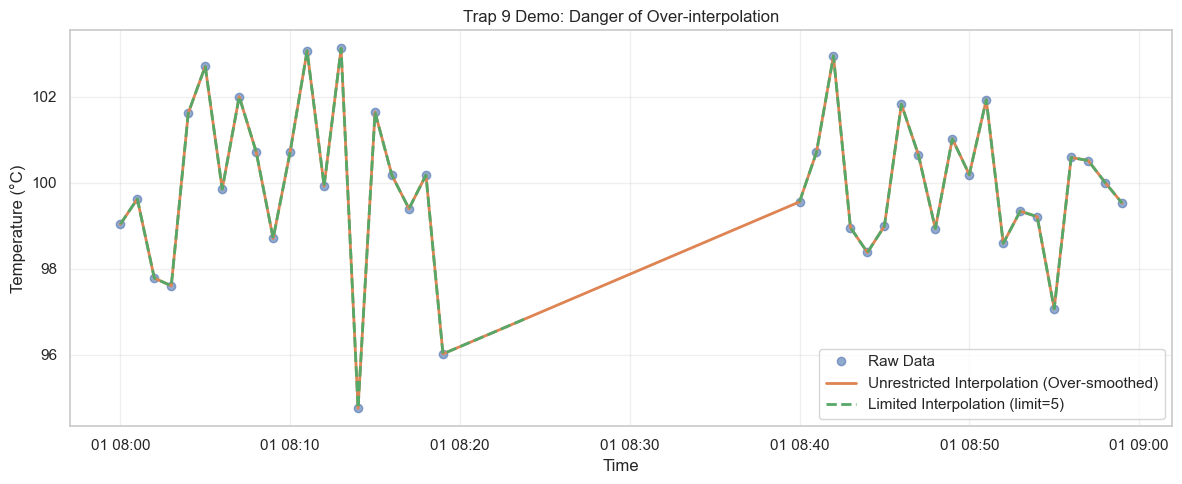

🎯 教訓：長時間缺失（>5-10分鐘）應保留 NaN 或標記為停機，不該硬補！


In [23]:
# 陷阱案例：長時間缺失用插值會創造「虛假平滑」
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 模擬數據：中間有長時間缺失（代表設備停機）
idx = pd.date_range('2023-01-01 08:00', periods=60, freq='1min')
data = np.concatenate([
    np.random.normal(100, 2, 20),  # 正常段1
    [np.nan] * 20,                  # 停機 20 分鐘
    np.random.normal(100, 2, 20)   # 正常段2
])
df_demo = pd.DataFrame({'Temperature': data}, index=idx)

# 錯誤做法：無限制插值
df_demo['Temp_Bad'] = df_demo['Temperature'].interpolate(method='time')

# 正確做法：限制插值長度
df_demo['Temp_Good'] = df_demo['Temperature'].interpolate(method='time', limit=5)

# 視覺化比較
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_demo.index, df_demo['Temperature'], 'o', label='Raw Data', alpha=0.6)
ax.plot(df_demo.index, df_demo['Temp_Bad'], '-', label='Unrestricted Interpolation (Over-smoothed)', linewidth=2)
ax.plot(df_demo.index, df_demo['Temp_Good'], '--', label='Limited Interpolation (limit=5)', linewidth=2)
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('Time')
ax.set_title('Trap 9 Demo: Danger of Over-interpolation')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('./Unit02_Results/trap09_over_interpolation.png', dpi=150)
plt.show()

print("🎯 教訓：長時間缺失（>5-10分鐘）應保留 NaN 或標記為停機，不該硬補！")

### 3.3 陷阱實例演示：時間洩漏（陷阱 6）

回顧 2.1-2.2 的滑動視窗與差分，強調「只使用歷史資訊」的重要性：

In [24]:
# 陷阱案例：使用「未來」資訊預測當下
import numpy as np
import pandas as pd

# 模擬時間序列
idx = pd.date_range('2023-01-01 09:00', periods=10, freq='1min')
temp = pd.Series([100, 102, 105, 110, 115, 112, 108, 105, 103, 101], index=idx)
df_leak = pd.DataFrame({'Temp': temp})

# ❌ 錯誤：使用「未來 5 分鐘平均」（會洩漏未來資訊）
df_leak['Future_MA'] = df_leak['Temp'].shift(-5).rolling(5).mean()

# ✅ 正確：使用「過去 5 分鐘平均」（只用歷史）
df_leak['Past_MA'] = df_leak['Temp'].rolling(5, min_periods=1).mean()

# ❌ 錯誤：shift 負值 = 取未來值
df_leak['Future_Temp'] = df_leak['Temp'].shift(-3)  # 洩漏！

# ✅ 正確：shift 正值 = 取過去值
df_leak['Past_Temp'] = df_leak['Temp'].shift(3)

print("時間洩漏檢查範例：")
print(df_leak[['Temp', 'Past_MA', 'Past_Temp']])
print("\n🎯 關鍵規則：")
print("  - rolling() 預設向後看（安全）")
print("  - shift(正值) = 向過去（安全）")
print("  - shift(負值) = 向未來（危險！）")
print("  - 中心化窗口 (center=True) 在即時預測中也是洩漏！")

時間洩漏檢查範例：
                     Temp     Past_MA  Past_Temp
2023-01-01 09:00:00   100  100.000000        NaN
2023-01-01 09:01:00   102  101.000000        NaN
2023-01-01 09:02:00   105  102.333333        NaN
2023-01-01 09:03:00   110  104.250000      100.0
2023-01-01 09:04:00   115  106.400000      102.0
2023-01-01 09:05:00   112  108.800000      105.0
2023-01-01 09:06:00   108  110.000000      110.0
2023-01-01 09:07:00   105  110.000000      115.0
2023-01-01 09:08:00   103  108.600000      112.0
2023-01-01 09:09:00   101  105.800000      108.0

🎯 關鍵規則：
  - rolling() 預設向後看（安全）
  - shift(正值) = 向過去（安全）
  - shift(負值) = 向未來（危險！）
  - 中心化窗口 (center=True) 在即時預測中也是洩漏！


---
## 🎓 Unit02 學習總結

**你已經掌握的技能**：
1. ✅ 時間序列基礎處理（轉換、插值、重採樣、填充）
2. ✅ 製程監控特徵工程（滑動視窗、差分、波動偵測）
3. ✅ 數據健康檢查與陷阱診斷

**下一步學習方向**：
- **Unit03**：理解 Batch vs Continuous 數據的差異與結構化
- **Unit04**：Train/Test Split、標準化與 Pipeline（避免陷阱 10）
- **Unit05+**：將這些技巧應用到實際化工案例（反應動力學、製程優化等）

**最佳實務提醒**：
- 每個新專案先執行健康檢查
- 遇到問題回顧本單元的陷阱清單
- 建立自己的數據前處理 SOP

> 💪 恭喜完成 Unit02！你已經具備處理化工時序數據的核心能力。